# Когда пытаешься понять, как сохранять модели tf2

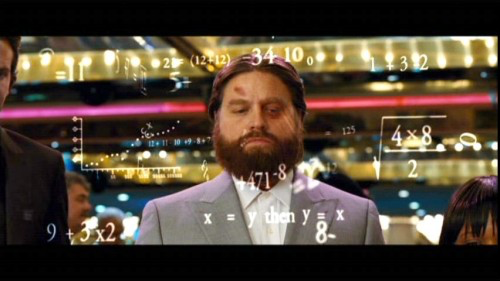

Второго июня 2020 вышло обновление документации про сохранение/загрузку моделей в keras / tf. Когда я проверял д/з, был очень удивлен, что не могу найти старую страницу и не нахожу тех вещей, которые *помню*. Потом я увидел дату обновления и решил подробно расписать, что теперь происходит. Кстати, вот [ссылка](https://www.tensorflow.org/guide/keras/save_and_serialize) на новую документацию.


Я немного полазал в wayback machine, но в итоге решил просто написать про современное состояние.

Возможно, этот документ неточен. Если заметите ошибки или что-то не будет работать на ваших версиях tf/keras, напишите (сразу с версией библиотеки).

# Определяйте get_config:

* Если нужно сохранить модель в .h5 (устаревший формат из "старого" `keras`)
* Если нужно использовать `get_config` для получения конфига

# В остальных случаях в `tf2.2` это можно не делать
* tensorflow сохраняет все нужные свойства слоев в графе и работает с графом. Достаточно `model.save` / `load_model`. В более старых версиях поведение может отличаться. 02.06.2020 обновили документацию на сохранение и загрузку - я пока не сравнивал старую и новую версии.
* Важно: до `tf2.2` subclassed-модели (т.е. модели `class MyModel(keras.Model)`) нельзя сохранить при помощи `model.save` / `load_model`. В 2.2 - я проверяю пока, как это работает. Поскольку их нельзя сохранить таким образом, нужно использовать `keras.get_config` и `keras.save_weigths`. 



In [0]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.layers as layers

# Без get_config нельзя сохранить .h5

In [2]:
class MyLayer(layers.Layer):
  def __init__(self, param, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.param = param

  def call(self, inputs):
    return inputs


input = layers.Input(shape=(10,))
x = MyLayer(1)(input)
model = keras.Model(input, x)

try:
  model.save('my_model.h5')
except Exception as e:
  print(e)

Layer MyLayer has arguments in `__init__` and therefore must override `get_config`.


# Для загрузки вам понадобится словарь custom_objects

In [3]:
class MyLayer(layers.Layer):
  def __init__(self, param, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.param = param

  def call(self, inputs):
    return inputs

  def get_config(self):
    base = super().get_config()
    base['param'] = self.param
    return base

input = layers.Input(shape=(10,))
x = MyLayer(1)(input)
model = keras.Model(input, x)

model.save('my_model.h5')
try:
  loaded = keras.models.load_model('my_model.h5',)
except Exception as e:
  print(e)
loaded = keras.models.load_model('my_model.h5', 
                                 custom_objects={'MyLayer': MyLayer})

Unknown layer: MyLayer


# Называйте параметры конструктора так же, как ключи словаря config

Потому что альтернативный конструкторв `from_config` реализован так:

```
@classmethod
def from_config(cls, config):
    return cls(**config)  # <-- ваш config из get_config
```

In [4]:
class MyLayer(layers.Layer):
  def __init__(self, std, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.std = std

  def call(self, inputs):
    return inputs

  def get_config(self):
    base = super().get_config()
    base['stddev'] = self.std
    return base

input = layers.Input(shape=(10,))
x = MyLayer(1)(input)
model = keras.Model(input, x)

model.save('my_model.h5')
try:
  loaded = keras.models.load_model('my_model.h5',
                                   custom_objects={'MyLayer': MyLayer})
except Exception as e:
  print(e)

__init__() missing 1 required positional argument: 'std'


In [0]:
model.save('my_model.h5')

# Как называется атрибут класса и что вы с ним делаете, не важно

In [9]:
class MyLayer(layers.Layer):
  def __init__(self, std, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.stddev = std  # <-- другое имя!

  def call(self, inputs):
    return inputs

  def get_config(self):
    base = super().get_config()
    base['std'] = self.stddev
    return base

input = layers.Input(shape=(10,))
x = MyLayer(1)(input)
model = keras.Model(input, x)

model.save('my_model.h5')  # added by me


loaded = keras.models.load_model('my_model.h5',
                                 custom_objects={'MyLayer': MyLayer})

# tfmodel фомат сохраняется/загружается без get_config

In [10]:
class MyLayer(layers.Layer):
  def __init__(self, param, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.param = param

  def call(self, inputs):
    return inputs


input = layers.Input(shape=(10,))
x = MyLayer(1)(input)
model = keras.Model(input, x)

model.save('my_model')
loaded = keras.models.load_model('my_model')


INFO:tensorflow:Assets written to: my_model/assets


# Но у ваших объектов не будет нужных атрибутов

In [13]:
try:
  print(loaded.layers[1].param)  # changed to 'loaded' by me
except Exception as e:
  print(e)

'MyLayer' object has no attribute 'param'


# Если добавить get_config, они не "появятся" :(

  (если эти параметры попали в граф, они в нем все еще есть)

In [12]:
class MyLayer(layers.Layer):
  def __init__(self, param, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.param = param

  def call(self, inputs):
    return inputs

  def get_config(self):
    base = super().get_config()
    base['param'] = self.param
    return base

input = layers.Input(shape=(10,))
x = MyLayer(1)(input)
model = keras.Model(input, x)

model.save('my_model')
loaded = keras.models.load_model('my_model')
try:
  print(loaded.layers[1].param)
except Exception as e:
  print(e)

INFO:tensorflow:Assets written to: my_model/assets
'MyLayer' object has no attribute 'param'


In [14]:
model.layers[1].param

1

# Но можно сохранять/загружать их через get_config

In [15]:
class MyLayer(layers.Layer):
  def __init__(self, param, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.param = param

  def call(self, inputs):
    return inputs

  def get_config(self):
    base = super().get_config()
    base['param'] = self.param
    return base


input = layers.Input(shape=(10,))
x = MyLayer(1)(input)
model = keras.Model(input, x)

model.save('my_model')
loaded = keras.models.load_model('my_model')

INFO:tensorflow:Assets written to: my_model/assets


In [0]:
config = model.get_config()

In [0]:
loaded = keras.Model.from_config(config, custom_objects={'MyLayer': MyLayer})

In [18]:
  print(loaded.layers[1].param)

1


# Вывод
Если нужно, определяйте get_config. Следите, чтобы возвращаемый словарь соотвествовал сигнатуре `__init__`. Передавайте объекты через `custom_objects`. Желательно обновить tf2.x до последней стабильной версии.



# Сохранение метрик

Я читал, что Пользовательские метрики с сигнатурой, аналогичной `fn(y_true, y_pred)`, (скоро?) должны сохраняться/загружаться _без_ дополнительных усилий (т.е. `get_config`).

Но не могу найти ссылку - но пока это не совсем так:

In [19]:
print(tf.__version__)

2.2.0


In [0]:
def my_metric(y_true, y_pred):
  return tf.reduce_mean(tf.abs(y_true - y_pred))

In [0]:
model = keras.Sequential([layers.Dense(10), layers.Dense(10)])
model.compile('adam', 'mse', metrics=[my_metric])

In [0]:
data = np.random.normal(0, 1, (100, 10))

# Кстати, Sequential без заданных входов не сохранится

In [23]:
try:
  model.save('my_model')
except Exception as e:
  print(e)

Model <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4aae17e048> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined from calling .fit() or .predict(). To manually set the shapes, call model._set_inputs(inputs).


Можно задать их вручную (сообщение выще), задав `input_shape` или вызвав `fit`/`predict`.

In [24]:
model.fit(data, data)

4/4 [==============================] - 0s 4ms/step - loss: 2.2299 - my_metric: 1.1956


In [25]:
try:
  model.save('my_model')
except Exception as e:
  print(e)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model/assets


# Надо передать свою метрику как custom object

In [26]:
try:
  loaded = keras.models.load_model('my_model')
except Exception as e:
  print(e)

Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.


In [0]:
loaded = keras.models.load_model('my_model', custom_objects={'my_metric': my_metric})

In [28]:
loaded.fit(data, data)

4/4 [==============================] - 0s 3ms/step - loss: 2.1545 - my_metric: 1.1380


# Сохранение subclassed model
(такой модели, которая наследует `keras.Model`)


In [30]:
class MyModel(keras.Model):
  def __init__(self, units):
    super(MyModel, self).__init__()
    self.my_layers = []
    for unit in units:
      self.my_layers.append(layers.Dense(unit))
  
  def call(self, inputs):
    for layer in self.my_layers:
      inputs = layer(inputs)
    return inputs

my_model = MyModel([10, 10])
data = np.random.normal(0, 1, (100, 10))

my_model.compile('adam', 'mse')
my_model.fit(data, data)

4/4 [==============================] - 0s 2ms/step - loss: 1.7975


# До 2.2 (или 2.1? я пока не проверял) нельзя было сохранить subclassed model

* Т.е. модель, наследуюущую `keras.Model`. Вы бы увидели `NotImplementedError`.
* А в современной версии можно, все работает:

In [31]:
my_model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


In [0]:
loaded = keras.models.load_model('my_model')

In [33]:
loaded.fit(data, data)

4/4 [==============================] - 0s 3ms/step - loss: 1.7364


# Странно, что в отличие от загрузки отдельных слоев, атрибуты модели появляются после загрузки:

In [34]:
loaded.my_layers

ListWrapper([<tensorflow.python.keras.layers.core.Dense object at 0x7f4aae07f6d8>, <tensorflow.python.keras.layers.core.Dense object at 0x7f4aac32e0f0>])

Даже если это новый интерпретатор и ваш наследующий класс пока не определен. Я полазаю по коду, чтобы разобраться - это неожиданно (чтобы проверить это, я перезапуска runtime).

In [0]:
try:
  MyModel([10, 10])
except NameError as e:
  print(e)

# В более старых версиях можно было использовать save_weights и get_config, но нужно было определять соотвествующие методы.

In [36]:
class MyModel(keras.Model):
  def __init__(self, units):
    super(MyModel, self).__init__()
    self.my_layers = []
    for unit in units:
      self.my_layers.append(layers.Dense(unit))
  
  def call(self, inputs):
    for layer in self.my_layers:
      inputs = layer(inputs)
    return inputs

my_model = MyModel([10, 10])
data = np.random.normal(0, 1, (100, 10))

my_model.compile('adam', 'mse')
my_model.fit(data, data)

4/4 [==============================] - 0s 2ms/step - loss: 1.3342


# И еще - subclassed model не сохраняется в .h5 (см. сообщение об ошибке)

In [37]:
try:
  my_model.save('my_model.h5')
except Exception as e:
  print(e)

Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
